# Dataset cleaning

## Libraries and datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import catboost as cat_
import lightgbm as lgb
import time


from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

## Feature engineering

Drop MPG because of the same value in each row.

In [4]:
train.drop(['MRG'], axis = 1, inplace=True)
test.drop(['MRG'], axis = 1, inplace=True)

Drop user_id from train

In [5]:
train.drop(['user_id'], axis = 1, inplace=True)
test.drop(['user_id'], axis = 1, inplace=True)

Drop top packs for the first iteration 

In [6]:
train.drop(['TOP_PACK'], axis = 1, inplace=True)
test.drop(['TOP_PACK'], axis = 1, inplace=True)

Convert tenure into the int format

In [7]:
train['TENURE'] = train['TENURE'].map({'K > 24 month': 24, 'I 18-21 month': 18, 'H 15-18 month': 15, 
                                       'G 12-15 month':12, 'J 21-24 month': 21, 'F 9-12': 9,
                                       'E 6-9 month':6, 'D 3-6 month':3})

In [8]:
test['TENURE'] = test['TENURE'].map({'K > 24 month': 24, 'I 18-21 month': 18, 'H 15-18 month': 15, 
                                       'G 12-15 month':12, 'J 21-24 month': 21, 'F 9-12': 9,
                                       'E 6-9 month':6, 'D 3-6 month':3})

In [9]:
train['TENURE'].fillna(1, inplace=True) # fill nans with unkown
test['TENURE'].fillna(1, inplace=True)

X and y split

In [10]:
y = train['CHURN']
train.drop(['CHURN'], axis = 1, inplace=True)

In [11]:
X = train

Train-val split

In [12]:
X, X_val, y, y_val = train_test_split(X,y,test_size = 0.2,random_state=1)

Encoding of categorical features

In [13]:
X['REGION'].fillna('other', inplace=True) # fill nans with unkown
X_val['REGION'].fillna('other', inplace=True) 
test['REGION'].fillna('other', inplace=True)

In [14]:
encoder = LabelEncoder() 
X['REGION'] = encoder.fit_transform(X['REGION'])
X_val['REGION'] = encoder.transform(X_val['REGION'])
test['REGION'] = encoder.transform(test['REGION'])

Scaling

In [15]:
num_cols = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE',
       'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2',
       'REGULARITY', 'FREQ_TOP_PACK']

In [16]:
scaler = StandardScaler()

In [17]:
X[num_cols] = scaler.fit_transform(X[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

Imputing missing values

In [18]:
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imp = imp.fit(X[num_cols])

In [19]:
X[num_cols] = imp.transform(X[num_cols])
X_val[num_cols] = imp.transform(X_val[num_cols])
test[num_cols] = imp.transform(test[num_cols])

## Models

In [20]:
def eval_metrics(y_test, y_pred):
    print('Precision Score: ', round(precision_score(y_val, y_pred), 3))
    print('Recall Score: ', round(recall_score(y_val, y_pred), 3))
    print('F1 Score: ', round(f1_score(y_val, y_pred), 3))
    print('Accuracy Score: ', round(accuracy_score(y_val, y_pred), 3))
    print('ROC AUC: ', round(roc_auc_score(y_val, y_pred), 3))

Submission preparation

In [21]:
submission = pd.read_csv('SampleSubmission.csv')

In [22]:
def prepare_submission(submission, test, model, name):
    sub_pred = model.predict(test)
    submission['CHURN'] = sub_pred
    return submission.to_csv(name, index=False)

### Decision tree

In [74]:
param_grid = {'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
              'ccp_alpha': [0.1, .01, .001],
              'min_samples_leaf': [3, 4, 5, 6, 7],
              'max_depth' : [5, 6, 7],
              'criterion' :['gini', 'entropy']
             }

tree_clas = DecisionTreeClassifier(random_state=124)
grid_search = HalvingGridSearchCV(estimator=tree_clas, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=False)
grid_search.fit(X, y)

HalvingGridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=124),
                    param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                                'criterion': ['gini', 'entropy'],
                                'max_depth': [5, 6, 7],
                                'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
                                'min_samples_leaf': [3, 4, 5, 6, 7]},
                    scoring='roc_auc', verbose=False)

In [75]:
grid_search.best_params_  

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 0.5,
 'min_samples_leaf': 7}

In [76]:
grid_search.best_score_

0.9227243529538033

In [77]:
tree_clas = DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=7,
                                   max_features=0.5, min_samples_leaf=7, random_state=124)
tree_clas.fit(X, y)

tree_ypred = tree_clas.predict(X_val)

In [78]:
eval_metrics(y_val, tree_ypred)

Precision Score:  0.652
Recall Score:  0.712
F1 Score:  0.681
Accuracy Score:  0.875
ROC AUC:  0.812


In [79]:
prepare_submission(submission, test, tree_clas, '1_tree_submission.csv')

### Random forest 

In [83]:
param_grid = {'n_estimators': [100, 200, 500],
              'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth' : [4,5,6,7,8,10],
              'criterion' :['gini', 'entropy']
             }

rand = RandomForestClassifier(random_state=124)
grid_search_rfc = HalvingGridSearchCV(estimator=rand, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=False)
grid_search_rfc.fit(X, y)
grid_search_rfc.best_score_ 

0.9307100441718875

In [84]:
grid_search_rfc.best_params_  

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 0.5,
 'n_estimators': 500}

In [44]:
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=8,
                                 max_features=0.5, n_estimators = 500, random_state=124)
rf_clf.fit(X, y)

rf_ypred = rf_clf.predict(X_val)
eval_metrics(y_val, rf_ypred)

Precision Score:  0.689
Recall Score:  0.646
F1 Score:  0.667
Accuracy Score:  0.879
ROC AUC:  0.79


In [45]:
prepare_submission(submission, test, rf_clf, '2_randforest_submission.csv')

In [46]:
features_dict = {'feature': X.columns, 'importance_level': rf_clf.feature_importances_}
features_df = pd.DataFrame(data=features_dict).sort_values(by='importance_level', ascending=False)

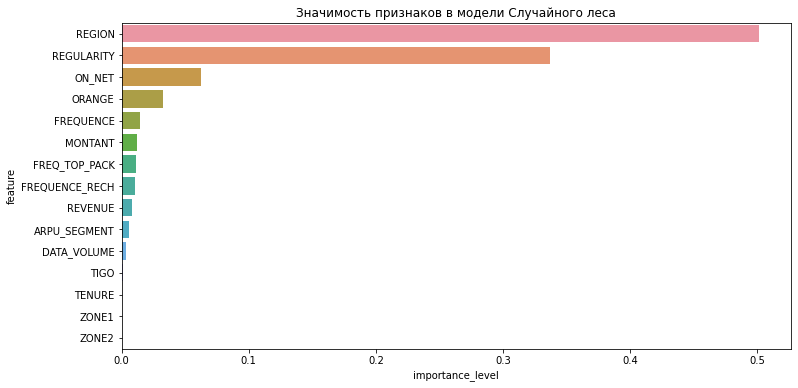

In [48]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title('Значимость признаков в модели Случайного леса')
sns.barplot(data=features_df, y='feature', x='importance_level', orient='h')
plt.show()

### Gradient boosting

In [36]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth':[3,5,8],
              'max_features':['log2','sqrt'],
              'subsample':[0.5, 0.8, 1.0],
              'n_estimators':[100, 200, 500, 1000]
             }

gb = GradientBoostingClassifier(random_state=124)
grid_search_gb = HalvingGridSearchCV(estimator=gb, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=False)
grid_search_gb.fit(X, y)
grid_search_gb.best_score_ 

0.9303845240065867

In [37]:
grid_search_gb.best_params_  

{'learning_rate': 0.01,
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 1000,
 'subsample': 1.0}

In [23]:
gb_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='sqrt', 
                                    n_estimators=1000, subsample=1.0, random_state=124)
gb_clf.fit(X, y)

gb_ypred = gb_clf.predict(X_val)
eval_metrics(y_val, gb_ypred)

Precision Score:  0.687
Recall Score:  0.655
F1 Score:  0.67
Accuracy Score:  0.879
ROC AUC:  0.793


In [24]:
prepare_submission(submission, test, gb_clf, '3_gradientboosting_submission.csv')

### Knn KNeighborsClassifier 

In [27]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X, y)
knn_ypred = knn.predict(X_val)
eval_metrics(y_val, knn_ypred)

Precision Score:  0.679
Recall Score:  0.611
F1 Score:  0.644
Accuracy Score:  0.873
ROC AUC:  0.772


In [ ]:
prepare_submission(submission, test, knn, '3_knn_submission.csv')

### Naive bayes 

In [28]:
param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=20)}

nb = GaussianNB()
grid_search_nb = HalvingGridSearchCV(estimator=nb, param_grid=param_grid_nb, scoring='roc_auc', cv=5, verbose=False, n_jobs=-1)
grid_search_nb.fit(X, y)
grid_search_nb.best_score_

0.9038539329031247

In [29]:
grid_search_nb.best_params_

{'var_smoothing': 0.004281332398719396}

In [30]:
gnb_model = GaussianNB(var_smoothing = 0.00428)
gnb_model.fit(X, y)

gnb_pred = gnb_model.predict(X_val)
eval_metrics(y_val, gnb_pred)

Precision Score:  0.373
Recall Score:  0.952
F1 Score:  0.536
Accuracy Score:  0.691
ROC AUC:  0.792


In [31]:
prepare_submission(submission, test, gnb_model, '5_naivebayes_submission.csv')

### Logistic Regression

In [34]:
param_grid = {'solver': ['newton-cg', 'sag', 'lbfgs'],
              'penalty': ['l2', 'none'], 
              'C': np.logspace(-3,3,7)
              }

lr = LogisticRegression()
grid_search_lr = HalvingGridSearchCV(estimator=lr, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=False, n_jobs=-1)
grid_search_lr.fit(X, y)
grid_search_lr.best_score_

0.9202279592264739

In [35]:
grid_search_lr.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

In [38]:
lr_model =  LogisticRegression(C=0.01, penalty='l2', solver='newton-cg')
lr_model.fit(X, y)

lr_pred = lr_model.predict(X_val)
eval_metrics(y_val, lr_pred)

Precision Score:  0.65
Recall Score:  0.71
F1 Score:  0.679
Accuracy Score:  0.874
ROC AUC:  0.811


In [39]:
prepare_submission(submission, test, lr_model, '4_logisticregression_submission.csv')

### SVM (SVC)

In [24]:
from sklearn.kernel_approximation import Nystroem
from sklearn import svm

In [25]:
clf_svc = svm.LinearSVC()
feature_map_nystroem = Nystroem(gamma=.2, 
                                random_state=1, n_components=300)
data_transformed = feature_map_nystroem.fit_transform(X)
clf_svc.fit(data_transformed, y)

LinearSVC()

In [29]:
X_val_transformed = feature_map_nystroem.transform(X_val)
svc_pred = clf_svc.predict(X_val_transformed)
eval_metrics(y_val, svc_pred)

Precision Score:  0.681
Recall Score:  0.656
F1 Score:  0.668
Accuracy Score:  0.878
ROC AUC:  0.793


In [33]:
test_transformed = feature_map_nystroem.transform(test)
prepare_submission(submission, test_transformed, clf_svc, '5_svc_submission.csv')